In [1]:
import signac
from cmeutils.structure import gsd_rdf
from cmeutils.dynamics import msd_from_gsd
import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np
from shutil import copyfile
import os

In [2]:
from math import factorial
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """

    Parameters
    ----------
    y:
    window_size:
    order:
    deriv:
    rate:

    Returns
    -------

    """
    if not (isinstance(window_size, int) and isinstance(order, int)):
        raise ValueError("window_size and order must be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")

    order_range = range(order + 1)
    half_window = (window_size - 1) // 2
    b = np.mat(
        [
            [k ** i for i in order_range]
            for k in range(-half_window, half_window + 1)
        ]
    )
    m = np.linalg.pinv(b).A[deriv] * rate ** deriv * factorial(deriv)
    firstvals = y[0] - np.abs(y[1 : half_window + 1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window - 1 : -1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode="valid")


def moving_average_smoothing(raw_data, w):
        return np.convolve(raw_data, np.ones(w), "same")/w

In [3]:
project = signac.get_project("../learning-runs/bulk-systems-final-run/")

In [4]:
for job in project:
    print(job.id)
    print(job.sp.kT_quench, job.sp.density)
    print("------------------------------")

b7c1f1b16332dff975e2a7473b77372a
5.0 1.27
------------------------------
5e5c3b51d23ed6e39e313251d0dbe35d
2.8375 1.27
------------------------------
739ea04d649f4f17adfaf5f2f3b754f8
5.0 1.27
------------------------------
60ed358785ae03705be66c9b272ce197
6.5 1.27
------------------------------
283aeef61d11604d749f27c0802e2239
5.0 1.38
------------------------------
e460c04a0f6cb57ef557b331b142ba26
6.5 1.38
------------------------------
573168d031c1727e94a799603133f646
6.5 1.38
------------------------------
ff130cb7090ec33d421ef23c1f1fa0d1
5.0 1.38
------------------------------
f1745aeb690e7b8d0ede9a803231f37a
2.8375 1.27
------------------------------
0d3b70eaadd9b6a2bc8f7080ea8a80c6
2.8375 1.38
------------------------------
a30ee973ec6d0780eabee2083ce594f3
2.8375 1.38
------------------------------
104159c7ec03f563a718b9e16adefe6a
6.5 1.27
------------------------------


# RDF Plots at single density

5e5c3b51d23ed6e39e313251d0dbe35d 2.8375
b7c1f1b16332dff975e2a7473b77372a 5.0
104159c7ec03f563a718b9e16adefe6a 6.5


Text(0.5, 1.0, 'Density: 1.27 g/cm^3')

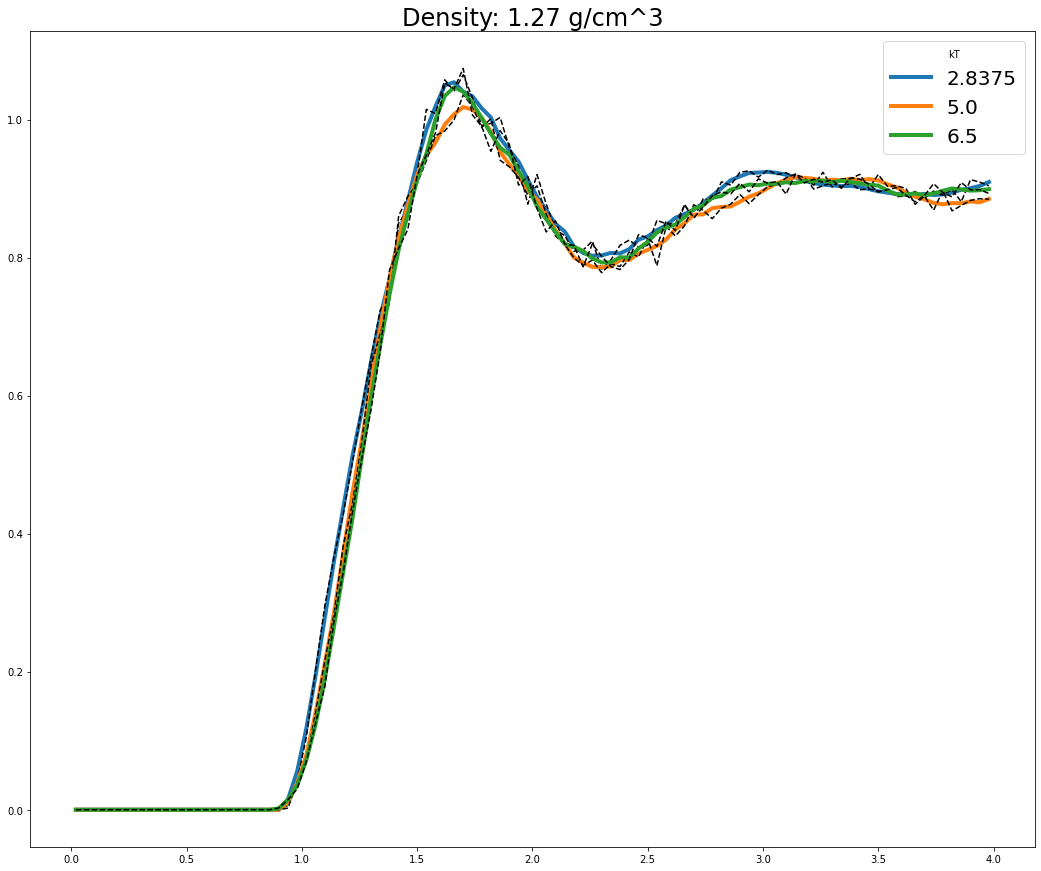

In [13]:
fig = plt.figure(figsize=(18, 15))
density = 1.27
for kT, job in project.find_jobs({"density": density}, {"done": True}).groupby("kT_quench"):
    job = list(job)[0]
    print(job.id, kT)
    rdf, norm = gsd_rdf(
        job.fn("components.gsd"),
        start=-30,
        stop=-1,
        A_name="K",
        B_name="K",
        r_max=4.0,
        exclude_bonded=True
    )
    
    # Plot smoothed RDF
    rdf_smooth = savitzky_golay(rdf.rdf*norm, window_size=9, order=2)
    where_neg = np.where(rdf_smooth < 0)
    rdf_smooth[where_neg[0]] = 0
    plt.plot(rdf.bin_centers, rdf_smooth, label=kT, linewidth=4)
    plt.plot(rdf.bin_centers, rdf.rdf * norm, "k--")
    
plt.legend(title="kT", fontsize=20)
plt.title(f"Density: {density} g/cm^3", fontsize=24)

# RDF Plots at single temperature

104159c7ec03f563a718b9e16adefe6a 6.5
573168d031c1727e94a799603133f646 6.5


Text(0.5, 1.0, 'kT: 6.5 g/cm^3')

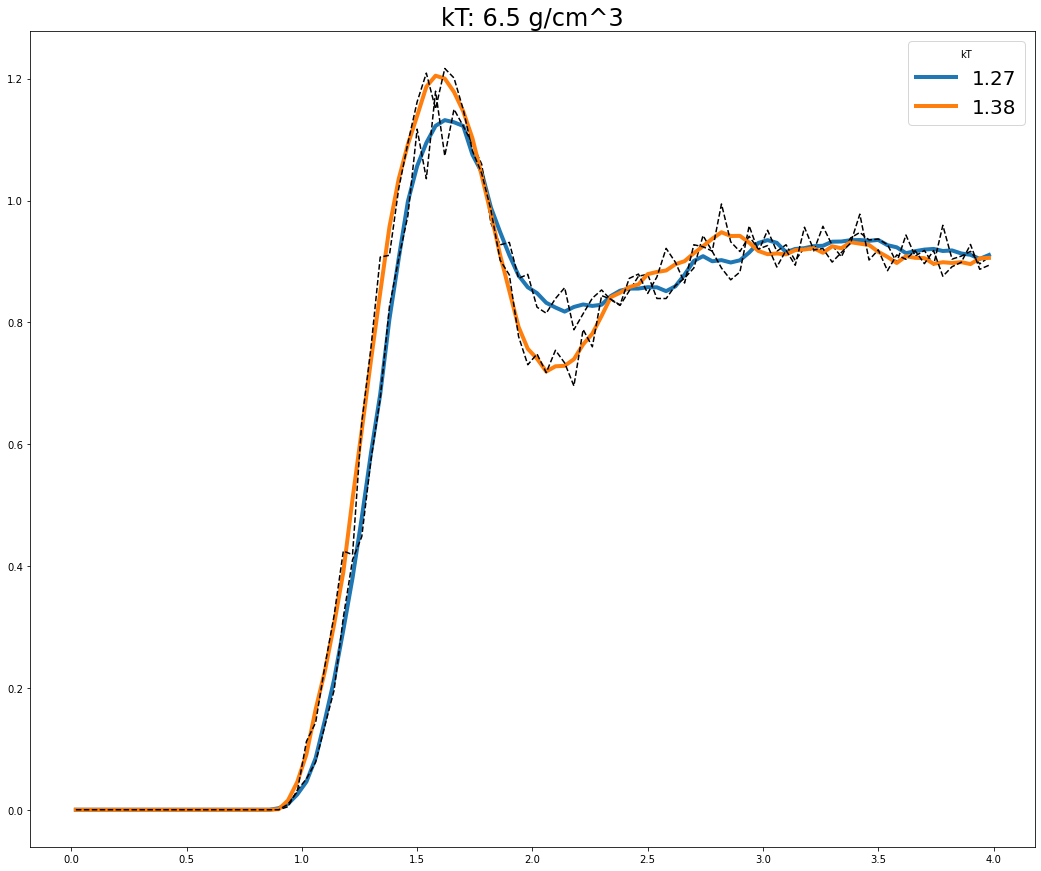

In [12]:
fig = plt.figure(figsize=(18, 15))
kT = 2.8375
kT = 5.0
kT = 6.5

for den, job in project.find_jobs({"kT_quench": kT}, {"done": True}).groupby("density"):
    job = list(job)[0]
    print(job.id, kT)
    rdf, norm = gsd_rdf(
        job.fn("components.gsd"),
        start=-30,
        stop=-1,
        A_name="E",
        B_name="E",
        r_max=4.0,
        exclude_bonded=True
    )
    
    # Plot smoothed RDF
    rdf_smooth = savitzky_golay(rdf.rdf*norm, window_size=9, order=2)
    where_neg = np.where(rdf_smooth < 0)
    rdf_smooth[where_neg[0]] = 0
    plt.plot(rdf.bin_centers, rdf_smooth, label=den, linewidth=4)
    plt.plot(rdf.bin_centers, rdf.rdf * norm, "k--")
    
plt.legend(title="kT", fontsize=20)
plt.title(f"kT: {kT} g/cm^3", fontsize=24)

# State points:
Amorphous density and melting temp
    - 83ec8a6b213ef7b9736c6effad94c08c
    
Crytalline density and room temp
    - 2817be04335215e6f13320a291433955

Amorphous and Crystalline density and Tg
    - Amorph: b4ee1106bd1032a03027f84810c536d0
    - Crystal: 0da6a51c797a1d747284d924eeac60a2

# Plotting all pairs at a given density and temperature

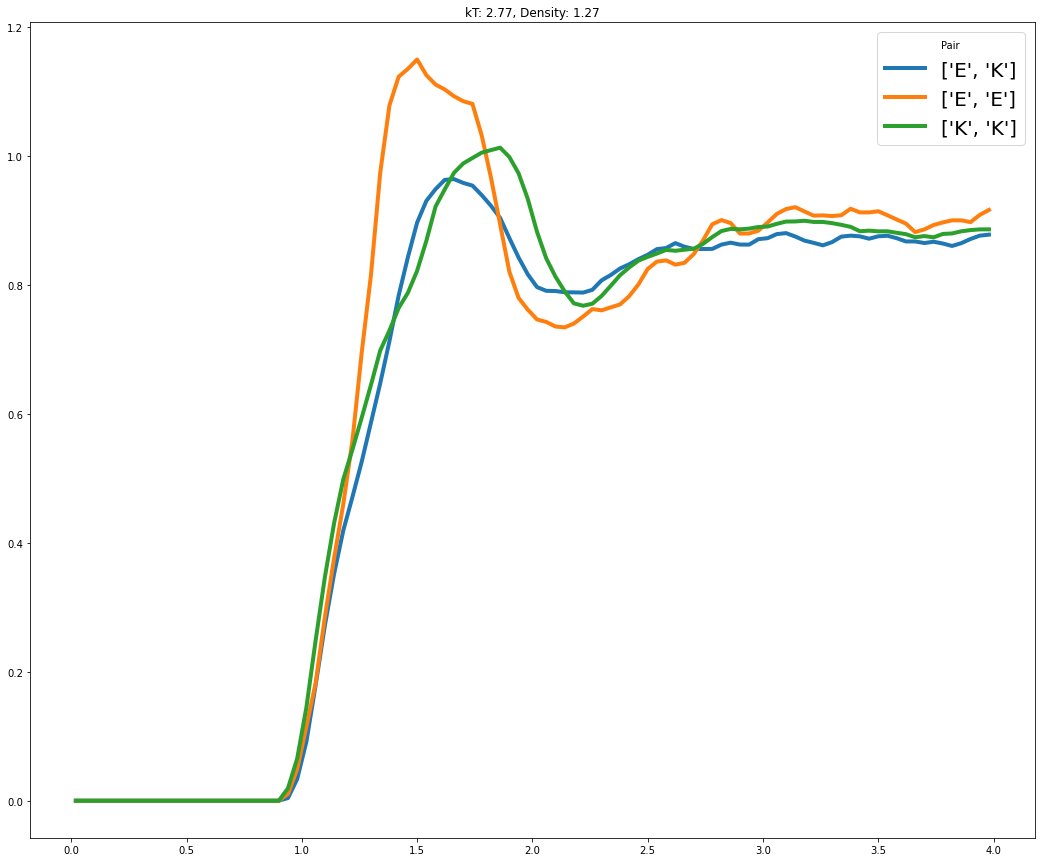

In [22]:
fig = plt.figure(figsize=(18, 15))
kT_quench = 2.77
density = 1.27
pairs = [["E", "K"], ["E", "E"], ["K", "K"]]

for kT, job in project.find_jobs(
    {"kT_quench": kT_quench, "density": density, "remove_hydrogens": True}).groupby("density"):
    
    job = list(job)[0]
    for pair in pairs:
        rdf, norm = gsd_rdf(
            job.fn("components.gsd"),
            start=-50,
            stop=-1,
            A_name=pair[0],
            B_name=pair[1],
            r_max=4.0,
            exclude_bonded=True
        )
        # Plot smoothed RDF
        rdf_smooth = savitzky_golay(rdf.rdf*norm, window_size=7, order=2)
        where_neg = np.where(rdf_smooth < 0)
        rdf_smooth[where_neg[0]] = 0
        plt.plot(rdf.bin_centers, rdf_smooth, label=pair, linewidth=4)

plt.title(f"kT: {kT_quench}, Density: {density}")
plt.legend(title="Pair", fontsize=20)

# Compare UA and AA

1e1177053eb33e8ee12d8551d470d0b5 False
83ec8a6b213ef7b9736c6effad94c08c True


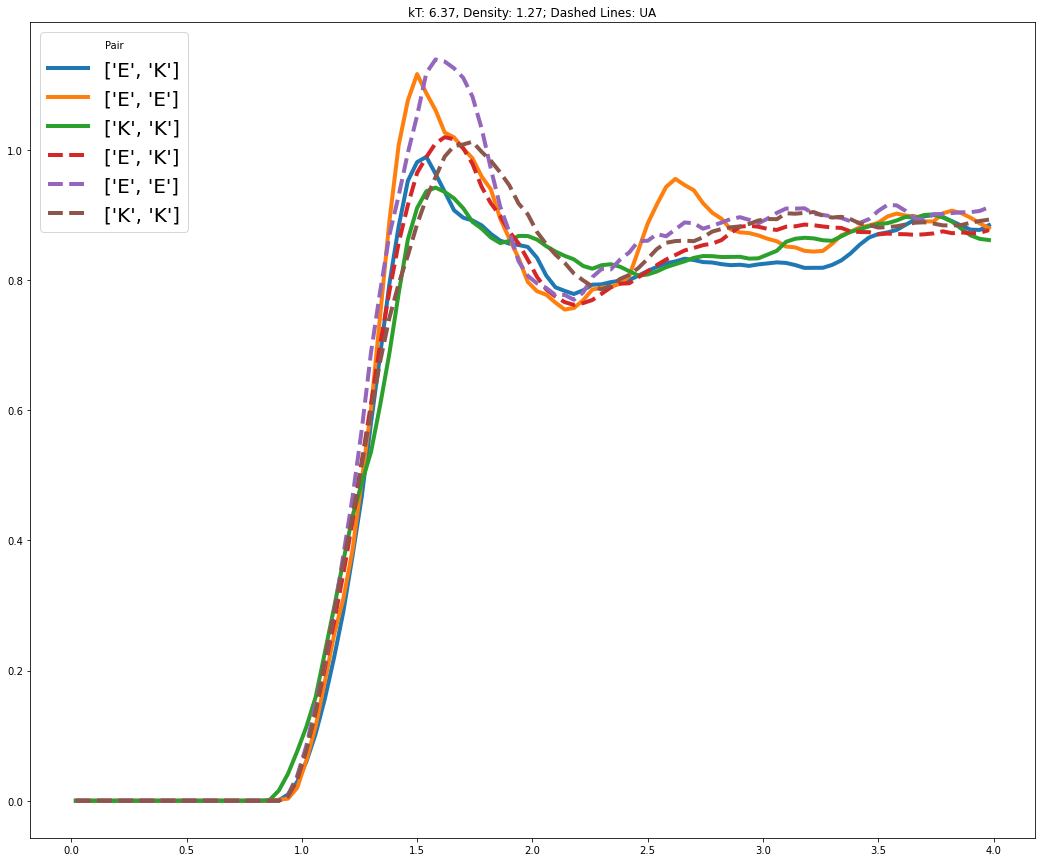

In [8]:
fig = plt.figure(figsize=(18, 15))
kT_quench = 6.37
density = 1.27
pairs = [["E", "K"], ["E", "E"], ["K", "K"]]

for h, job in project.find_jobs(
    {"kT_quench": kT_quench, "density": density}).groupby("remove_hydrogens"):
    
    job = list(job)[0]
    print(job.id, job.sp.remove_hydrogens)
    if h:
        ls = "--"
    else:
        ls = "-"
    
    for pair in pairs:
        rdf, norm = gsd_rdf(
            job.fn("components.gsd"),
            start=-50,
            stop=-1,
            A_name=pair[0],
            B_name=pair[1],
            r_max=4.0,
            exclude_bonded=True
        )
        # Plot smoothed RDF
        rdf_smooth = savitzky_golay(rdf.rdf*norm, window_size=7, order=2)
        where_neg = np.where(rdf_smooth < 0)
        rdf_smooth[where_neg[0]] = 0
        plt.plot(rdf.bin_centers, rdf_smooth, label=pair, linewidth=4, ls=ls)

plt.title(f"kT: {kT_quench}, Density: {density}; Dashed Lines: UA")
plt.legend(title="Pair", fontsize=20)